# Option A - ISRU efficiency

In [ ]:
pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from tqdm import tqdm

from PIL import Image, ImageTk, ImageMath, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000
import PIL.ImageGrab as ImageGrab

import cv2

import urllib
import os

import geopandas as gpd
import shapely
shapely.geos.geos_version
from shapely.ops import cascaded_union

# ISRU model

Model from Fran

In [2]:
# input weight percent Ilmenite
# output ISRU mass for production plant

def ISRU_mass(x):

    y0 =  4036*x**-1.064  -9.59   # Excavation
    y1 = 17580*x**-1.003  -390.8  # Handling
    y2 = 19240*x**-1.003  -421.9  # Beneficiation
    y3 = 21780*x**-1.198  +120.3  # O2 Extraction
    y4 = 17910*x**-1.265  +1370   # O2 Purification
    y5 = 29650*x**-0.7005 -602.5  # Metal Processing
    y6 =  2541*x**-0.7434 +286.8  # Gas Liquefaction & Storage
    y7 = 32440*x**-0.8312 +125.2  # Thermal Control
    y8 = 12000*x**-0.9657 +63.99  # Power

    y_sum = y0 + y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 
    
    return y_sum

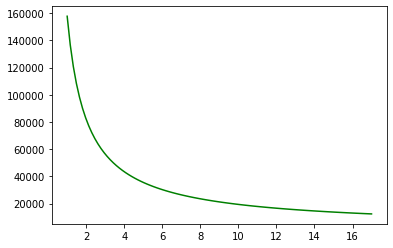

1 wt% 157718.5 kg
2 wt% 81930.32157138802 kg
11 wt% 17833.408009763454 kg


In [3]:
x = np.linspace(1,17,100)     # x goes from 1 to 17 wt.%
y = ISRU_mass(x)

plt.plot(x,y, 'g-')
plt.show()

print("1 wt%",ISRU_mass(1),"kg")
print("2 wt%",ISRU_mass(2),"kg")
print("11 wt%",ISRU_mass(11),"kg")

## Aquire global Ilmenite map

### helper functions for processing and figure plotting

In [4]:
res = 2000 # plot images will have this width in pixels
Lat_span = tuple((-90,90))
Lon_span = tuple((-180,180))

Lat_min, Lat_max = Lat_span
Lon_min, Lon_max = Lon_span
print("plotting area:", "Lon",tuple((Lon_min, Lon_max)),"Lat",tuple((Lat_min, Lat_max)))

aspect_ratio = (Lon_max-Lon_min)/(Lat_max-Lat_min)
resolution = tuple((res,int(res/aspect_ratio)))
resolution_im = tuple((int((360/(Lon_max-Lon_min))*res),
                            int((360/(Lon_max-Lon_min))*res/2)))
print("plotting image resolution:",resolution_im)


def resize_map(path):
    print("resize",path, 'to', resolution_im)
    image = Image.open("maps/" + path)
    print("original map image", "with extrema: ",image.getextrema())
    new_image = image.resize(resolution_im)
    print("resized map image", "with extrema: ",new_image.getextrema())

    return new_image

def resize_map_keep_min(path):
    print("resize",path, 'to', resolution_im)
    image = Image.open("maps/" + path)
    print("original map image", "with extrema: ",image.getextrema())
    min = image.getextrema()[0]
    new_image = image.resize(resolution_im)
    new_image.save('temp.png')
    new_image = cv2.imread('temp.png',0)
    new_image[new_image<min] = min # set everything below minimum to original minimum (1% to 1 w% = 22)
    cv2.imwrite('temp.png', new_image)
    new_image = Image.open("temp.png")
    print("resized map image", "with extrema: ",new_image.getextrema())
    os.remove("temp.png")

    return new_image

def read_im_values(im,value_divider):
    data = im.load()
    im_res = im.size

    Lat_use = np.linspace(Lat_max,Lat_min,resolution[1])
    print('Lat_use',np.min(Lat_use),np.max(Lat_use),Lat_use.shape, 'first Lat', Lat_use[0:5])
    Lon_use = np.linspace(Lon_min,Lon_max,resolution[0])
    print('Lon_use',np.min(Lon_use),np.max(Lon_use),Lon_use.shape, 'first Lon', Lon_use[0:5])

    print("     reading image values", "with extrema: ",im.getextrema())

    x = np.zeros(shape=(tuple((resolution[1],resolution[0]))))

    for n in tqdm(range(resolution[1])):

        index_y = round(np.interp(Lat_use[n], (-90,90), (im_res[1]-1,0)))

        for i in range(resolution[0]):
            index_x = round(np.interp(Lon_use[i], (-180, 180), (0, im_res[0]-1)))
            x[n][i] = data[index_x,index_y]/value_divider

    return x

        
def plot_map(values,value_devider,value_label,file_name,Lat_range,Lon_range,labelsize=None,save=None):
    
        if not labelsize: labelsize = 20
    
        Lat_min, Lat_max = Lat_range
        Lon_min, Lon_max = Lon_range
        
        min_value = np.min(values)
        max_value = np.max(values)
        
        print("display values",values.shape[::-1])
        print("extrema",min_value,max_value)
        
        plt.figure(figsize=(12,6), dpi=200)
        
        ax = plt.gca()
        im = ax.imshow(values, cmap='viridis', interpolation='None', 
                extent=[Lon_min,Lon_max,Lat_min,Lat_max])
        plt.xticks(np.arange(Lon_min, Lon_max+1, Lon_max/4))
        plt.yticks(np.arange(Lat_min, Lat_max+1, Lat_max/2))
        ax.tick_params(axis='both', which='major', labelsize=labelsize)
        # create an axes on the right side of ax. The width of cax will be 2%
        # of ax and the padding between cax and ax will be fixed at 0.4 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size=0.25, pad=0.4)

        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_ylabel(value_label, rotation=90, size=labelsize)

        labels = np.append(np.arange(min_value, max_value, value_devider), max_value)
        print('image value spread',labels)
        loc    = labels
        cbar.set_ticks(loc)
        
        if labels[0] == round(labels[0]):
            cbar.set_ticklabels(['{:.0f}'.format(x) for x in labels])
        else:
            cbar.set_ticklabels(labels)
        
        cbar.ax.tick_params(labelsize=labelsize)
            
        plt.tight_layout()
        #plt.savefig(file_name+'.svg')
        
        plt.draw()

        labels = [item for item in cbar.ax.get_yticks()]

        converted_value_labels = np.append(np.arange(min_value/value_devider, max_value/value_devider, 1), max_value/value_devider)
        labels = converted_value_labels
        
        formatted_labels = []
        for i , x in enumerate(labels):
            if i == 0 : formatted_labels.append('{:.2f}'.format(x))
            elif i == len(labels)-1: formatted_labels.append('{:.2f}'.format(x))
            else: formatted_labels.append('{:.0f}'.format(x))
        print('value_divided spread',formatted_labels)
        
        cbar.set_ticklabels(formatted_labels)
        
        if save: plt.savefig("doc/img/" + save, bbox_inches='tight',pad_inches = 0)
        
        plt.show()
        plt.close()
        
def plot_histogram(x,color):
    x = x.flatten()
    avg = np.mean(x)
    print("Average",avg)

    plt.hist(x, density=True, bins=range(0,256),color = color, lw=0)
    plt.ylabel('Probability')
    plt.xlabel('Data')
    plt.yscale('log')
    #plt.ylim(0, 0.01)
    plt.show()
    plt.close()

plotting area: Lon (-180, 180) Lat (-90, 90)
plotting image resolution: (2000, 1000)


### combine source TIF files

download TIF: https://wms.lroc.asu.edu/lroc/view_rdr/WAC_TIO2
<br>
readme https://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/WAC_TIO2/WAC_TIO2_README.TXT
<br>
file-browser http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/BROWSE/WAC_TIO2/

In [5]:
# combine source TIF

import sys
from PIL import Image

line1_images = [Image.open(x) for x in ['sources\map\WAC_TIO2_E350N2250.TIF', 'sources\map\WAC_TIO2_E350N3150.TIF', 'sources\map\WAC_TIO2_E350N0450.TIF','sources\map\WAC_TIO2_E350N1350.TIF']]
line2_images = [Image.open(x) for x in ['sources\map\WAC_TIO2_E350S2250.TIF', 'sources\map\WAC_TIO2_E350S3150.TIF', 'sources\map\WAC_TIO2_E350S0450.TIF','sources\map\WAC_TIO2_E350S1350.TIF']]

l1_widths, l1_heights = zip(*(i.size for i in line1_images))
l2_widths, l2_heights = zip(*(i.size for i in line2_images))

print('HEIGHTS',l1_heights,l2_heights)
print('WIDTHS',l1_widths,l2_widths)

for i in range (0, len(l1_heights)-1):
    if l1_widths[i] != l1_widths[i+1]:
        print('CRITICAL WARNING     different l1_widths detected',tuple((l1_widths[i],l1_widths[i+1])))

    if l1_heights[i] != l1_heights[i+1]:
        print('CRITICAL WARNING     different l1_heights detected',tuple((l1_heights[i],l1_heights[i+1])))

for i in range (0, len(l2_heights)-1):
    if l2_widths[i] != l2_widths[i+1]:
        print('CRITICAL WARNING     different l2_widths detected',tuple((l2_widths[i],l2_widths[i+1])))

    if l2_heights[i] != l2_heights[i+1]:
        print('CRITICAL WARNING     different l2_heights detected',tuple((l2_heights[i],l2_heights[i+1])))


if sum(l1_widths) == sum(l2_widths):
    print('SUCCESS  both line widths are matching')

total_height = max(l1_heights) + max(l2_heights)
total_width = max(sum(l1_widths), sum(l2_widths))

new_im = Image.new('L', (total_width, total_height))

x_offset = 0
y_offset = 0
for im in line1_images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

x_offset = 0
y_offset = max(l1_heights)
for im in line2_images:
  new_im.paste(im, (x_offset,y_offset))
  x_offset += im.size[0]

print("saving image ...")
new_im.save('maps/preparation/TiO2/WAC_TIO2_COMBINED_MAP_RAW.png')
#new_im.save('maps/preparation/TiO2/WAC_TIO2_COMBINED_MAP_RAW.TIF')
print('done.')

HEIGHTS (5321, 5321, 5321, 5321) (5321, 5321, 5321, 5321)
WIDTHS (6840, 6840, 6841, 6840) (6840, 6840, 6841, 6840)
CRITICAL WARNING     different l1_widths detected (6840, 6841)
CRITICAL WARNING     different l1_widths detected (6841, 6840)
CRITICAL WARNING     different l2_widths detected (6840, 6841)
CRITICAL WARNING     different l2_widths detected (6841, 6840)
SUCCESS  both line widths are matching
saving image ...
done.


In [6]:
# first and last line of the combined picture are empty     - cutting them away
# empty coloum after between 3rd and 4th piece in the lines - cutting them away
# empty lines are from source TIF images

data = np.array(Image.open("maps/preparation/TiO2/WAC_TIO2_COMBINED_MAP_RAW.png"))
print("input",data.shape)

print(np.count_nonzero(data==0),"Zeros found in Picture")
    
if data [0][0] == 0:
    
    print("removing first and last line")
    crop_data = np.delete(data,(0,data.shape[0]-1), axis=0)
    print(np.count_nonzero(crop_data==0),"Zeros found in Picture")
    
    print("removing coloum between 3rd and 4th picture in line")
    crop_data = np.delete(crop_data,(int(3* (data.shape[1]/4))), axis=1)
    print(np.count_nonzero(crop_data==0),"Zeros found in Picture")
    
    print("output",crop_data.shape)
    
    print("saving image ...")
    new_im = Image.fromarray(crop_data)
    new_im.save('maps/preparation/TiO2/WAC_TIO2_COMBINED_MAP.png')
    print("done.")
    
else: print("data seems fine already")

input (10642, 27361)
65362 Zeros found in Picture
removing first and last line
10640 Zeros found in Picture
removing coloum between 3rd and 4th picture in line
0 Zeros found in Picture
output (10640, 27360)
saving image ...
done.


### plot result for paper Figure

display values (27360, 10640)
extrema 22 255
image value spread [ 22  44  66  88 110 132 154 176 198 220 242 255]
value_divided spread ['1.00', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '11.59']


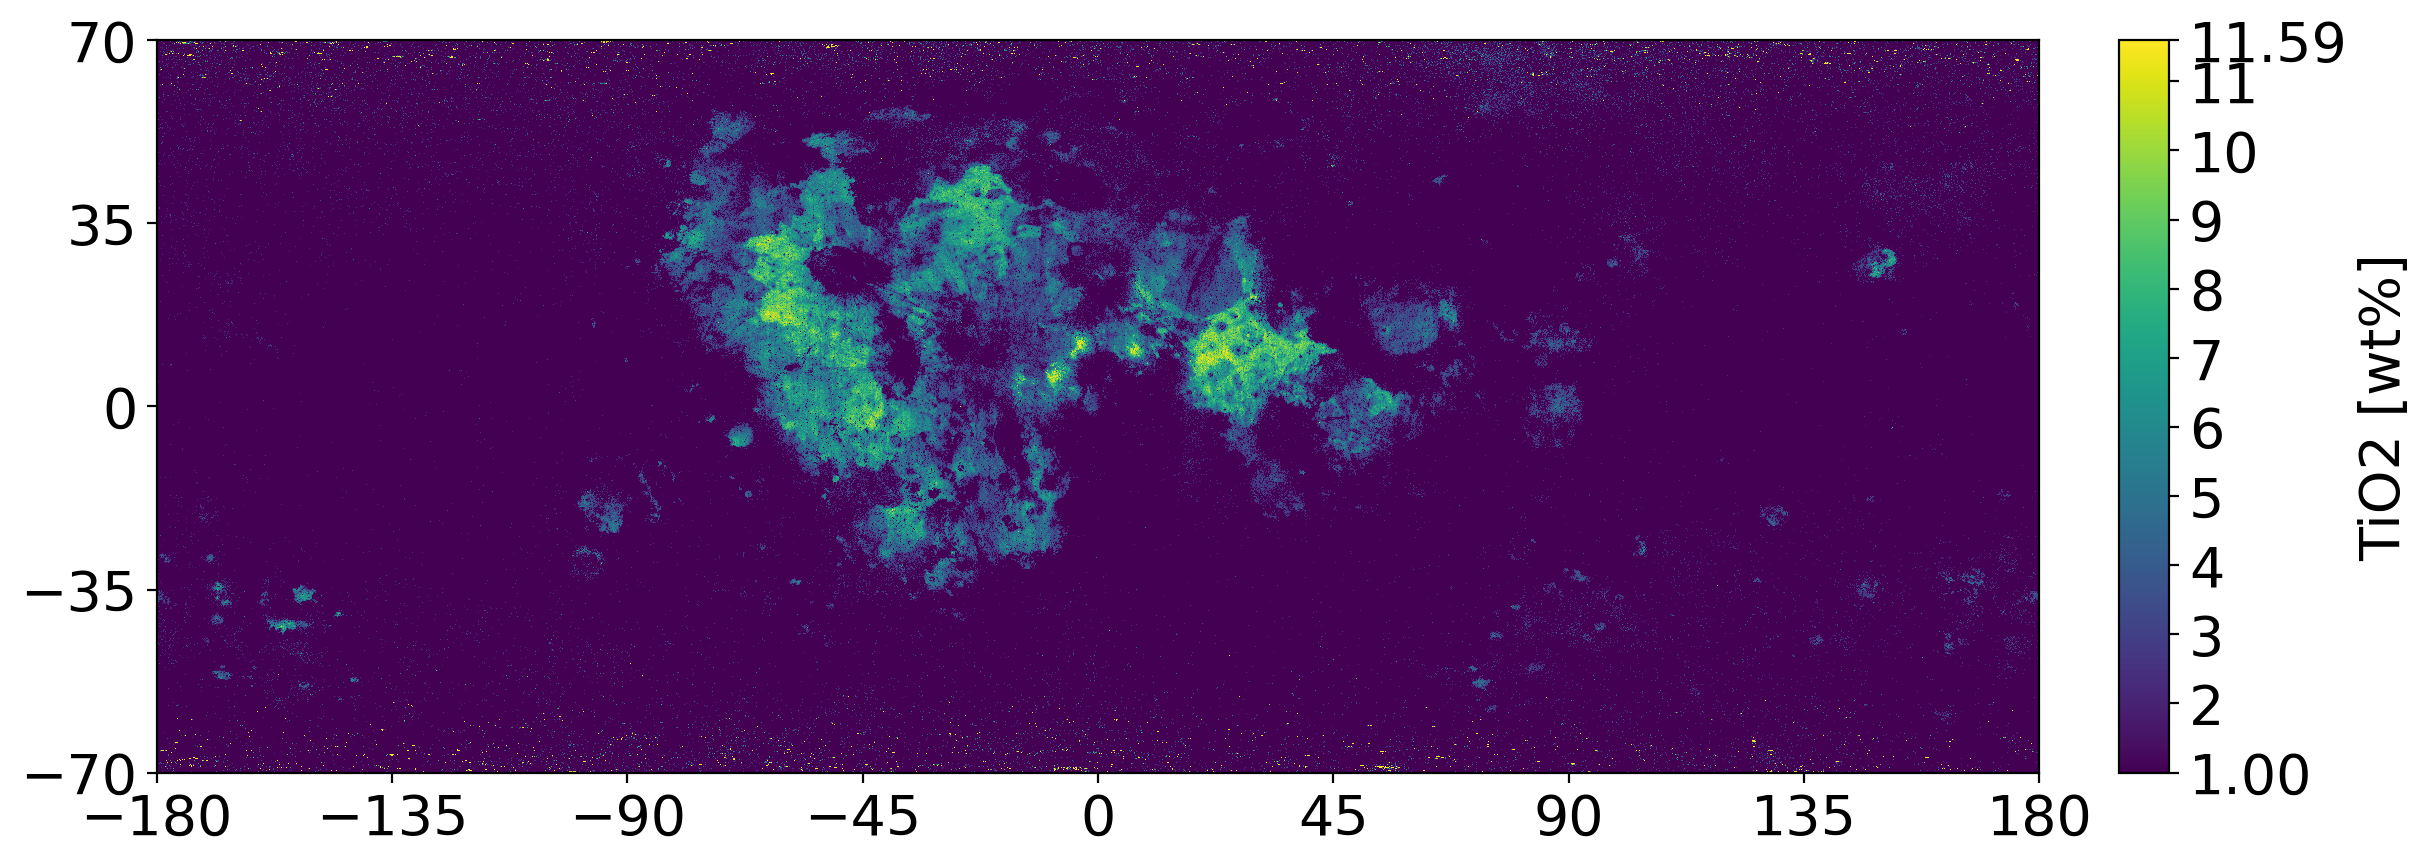

In [7]:
data = np.array(Image.open("maps/preparation/TiO2/WAC_TIO2_COMBINED_MAP.png"))
plot_map(data,22,'TiO2 [wt%]','TiO2',tuple((-70,70)),tuple((-180,180)),labelsize=20,save="WAC_TIO2_COMBINED_MAP.png")

display values (27361, 13680)
extrema 22 255
image value spread [ 22  44  66  88 110 132 154 176 198 220 242 255]
value_divided spread ['1.00', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '11.59']


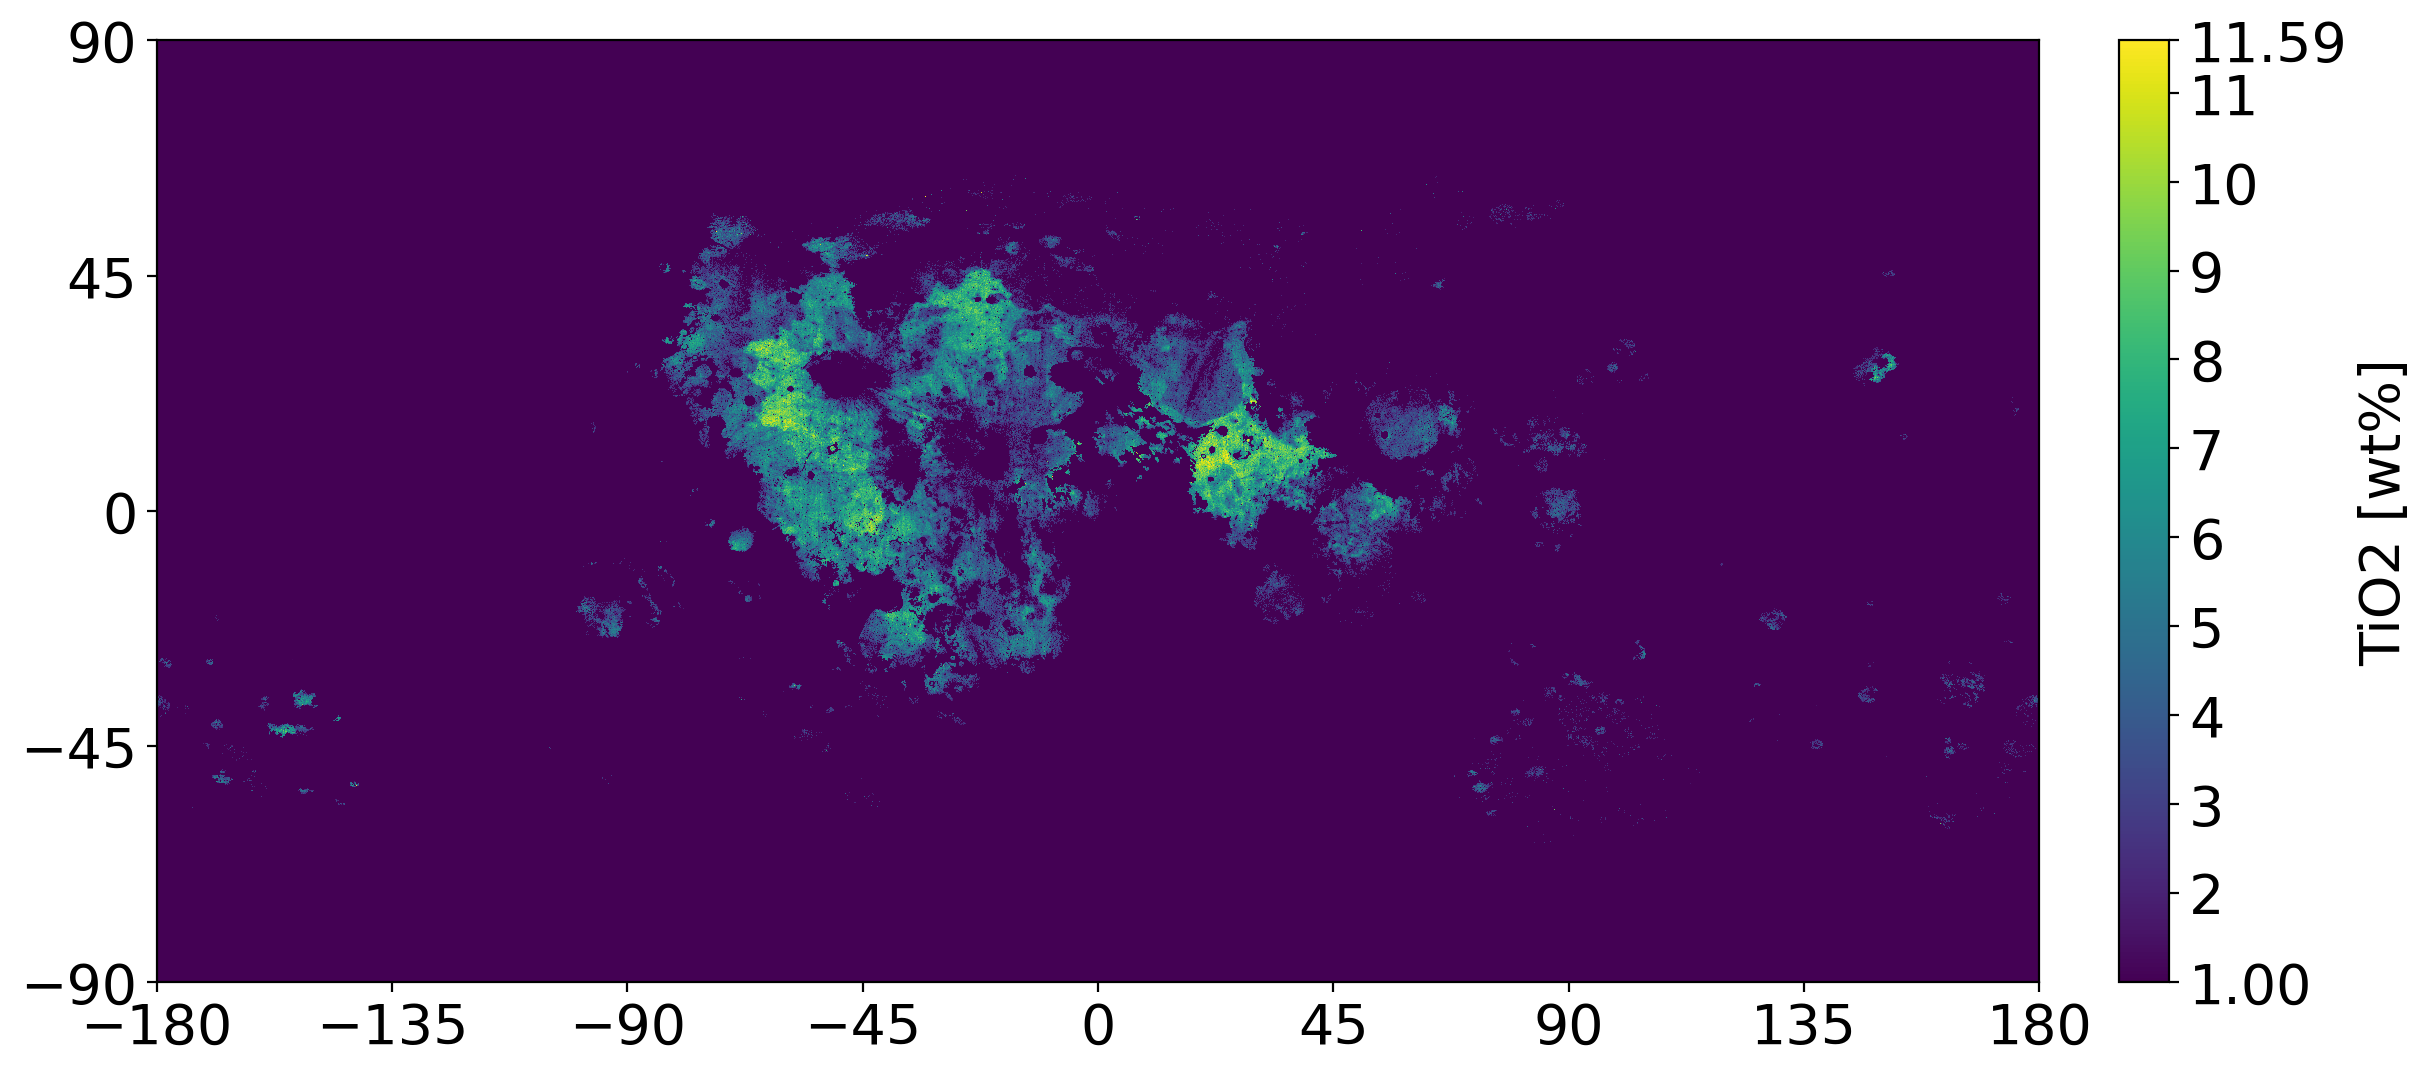

In [8]:
data = np.array(Image.open("maps/WAC_TIO2_GLOBAL_MASKED_MAP.png"))
plot_map(data,22,'TiO2 [wt%]','TiO2',tuple((-90,90)),tuple((-180,180)))

### loading mask from source, converting into BW image 

download: http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/SHAPEFILE/LROC_GLOBAL_MARE/LROC_GLOBAL_MARE_180.SHP
<br>
readme:   http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/SHAPEFILE/LROC_GLOBAL_MARE/LROC_GLOBAL_MARE_README.TXT
<br>
files:     http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/SHAPEFILE/LROC_GLOBAL_MARE/

In [9]:
# open shapefile in geopandas and plot in png

import geopandas
from shapely.geometry import Point,Polygon
from shapely.ops import unary_union
from tqdm import tqdm   # progreess bar
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
import numpy as np
import matplotlib.pyplot as plt


df = geopandas.read_file("sources\map\LROC_GLOBAL_MARE_180\LROC_GLOBAL_MARE_180.shp")
print(df)
df.plot("MARE_NAME", color="White", antialiased=False)
plt.axis('off')


print("saving ...")

# Mare map goes from 65N to 65S
# Mare (6px x 4px) per dpi
# to match (27360, 10640) -> 4560 dpi matching Longitude

# remove all whitespace padding around canvas
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('maps\preparation\TiO2\LROC_GLOBAL_MARE_180.png', dpi=4560,facecolor ='black', bbox_inches='tight',pad_inches = 0)

print("done.")
plt.close()

     ID        MARE_NAME   Perimtr_km       Area_km  \
0     1    Cognitum East  4157.317772  58602.592926   
1     0            Crger   151.939407   1312.065758   
2     0         Endymion   447.162294   6514.848991   
3     0    Mare Temporis   346.920443   1944.760025   
4     0     Schumacher B    66.471067    266.591729   
..   ..              ...          ...           ...   
639   0   Lacus Aestatis    25.427598     26.188966   
640   0          Rocca F    40.120928     63.678815   
641   0  Vasco da Gama R    38.287222     72.257063   
642   0  Vasco da Gama R    30.247695     34.644467   
643   0   Mare Orientale    17.668961     11.274133   

                                              geometry  
0    POLYGON ((-10.67021 -6.80306, -10.68354 -6.820...  
1    POLYGON ((-67.62647 -16.97267, -67.61314 -16.9...  
2    POLYGON ((54.73263 54.87587, 54.78062 54.92168...  
3    POLYGON ((57.48461 42.41091, 57.51602 42.48158...  
4    POLYGON ((59.64808 42.42007, 59.68210 42.37034...

C:\Users\svens\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


saving ...
done.


### adjusting mask .png to WAC resolution

In [10]:
# adjust mask .png (65N to 65S) to WAC resolution (70N to 70S) -> extend top and bottom with 5 deg
# height: 9979 px to 10640 px

im = Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180.png").convert('L')
print("LROC_GLOBAL_MARE_180.png opened.")

width, height = im.size
print("input",im.size)
new_width, new_height = (27360,10640)
print("output",tuple((new_width, new_height)))

# extending top and bottom 
pad = round((new_height - height)/2)
shift_offset = 69 # pixel measured offset - unknown reason for shift - manually align

new_im = Image.new('L', (new_width, new_height))
x_offset = 0
y_offset = pad + shift_offset
new_im.paste(im, (x_offset,y_offset))

print("saving results...")
new_im.save('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png')

print("creating NEG version...")
im = Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png")
im_invert = ImageOps.invert(im)
print("saving results...")
im_invert.save('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK_NEG.png')
print('COMPLETED.')


LROC_GLOBAL_MARE_180.png opened.
input (27360, 9979)
output (27360, 10640)
saving results...
creating NEG version...
saving results...
COMPLETED.


Average 40.14077365494328


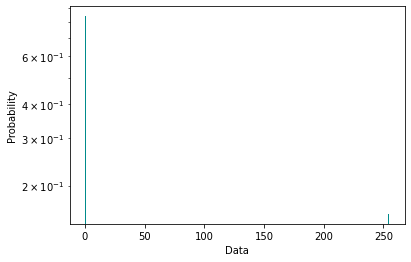

Average 214.85922634505673


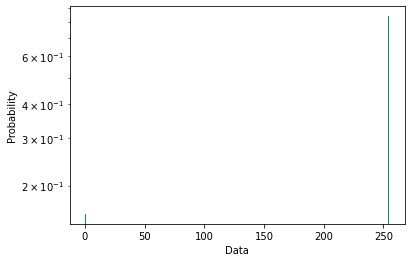

In [11]:
# test for only BW
x = np.array(Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png"))
plot_histogram(x, "darkcyan")

x = np.array(Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK_NEG.png"))
plot_histogram(x, "darkcyan")

### applying mask to combined map, create clustering

In [12]:
# apply masking

import cv2

image = cv2.imread('maps\preparation\TiO2\WAC_TIO2_COMBINED_MAP.png',0)

mask =     cv2.imread('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png',0)
mask_neg = cv2.imread('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK_NEG.png',0)

result_mare = cv2.bitwise_and(image, mask)
result_high = cv2.bitwise_and(image, mask_neg)

cv2.imwrite('maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_MARE.png', result_mare)
cv2.imwrite('maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_HIGH.png', result_high)

print('COMPLETED.')

COMPLETED.


display values (27360, 10640)
extrema 22 255
image value spread [ 22  44  66  88 110 132 154 176 198 220 242 255]
value_divided spread ['1.00', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '11.59']


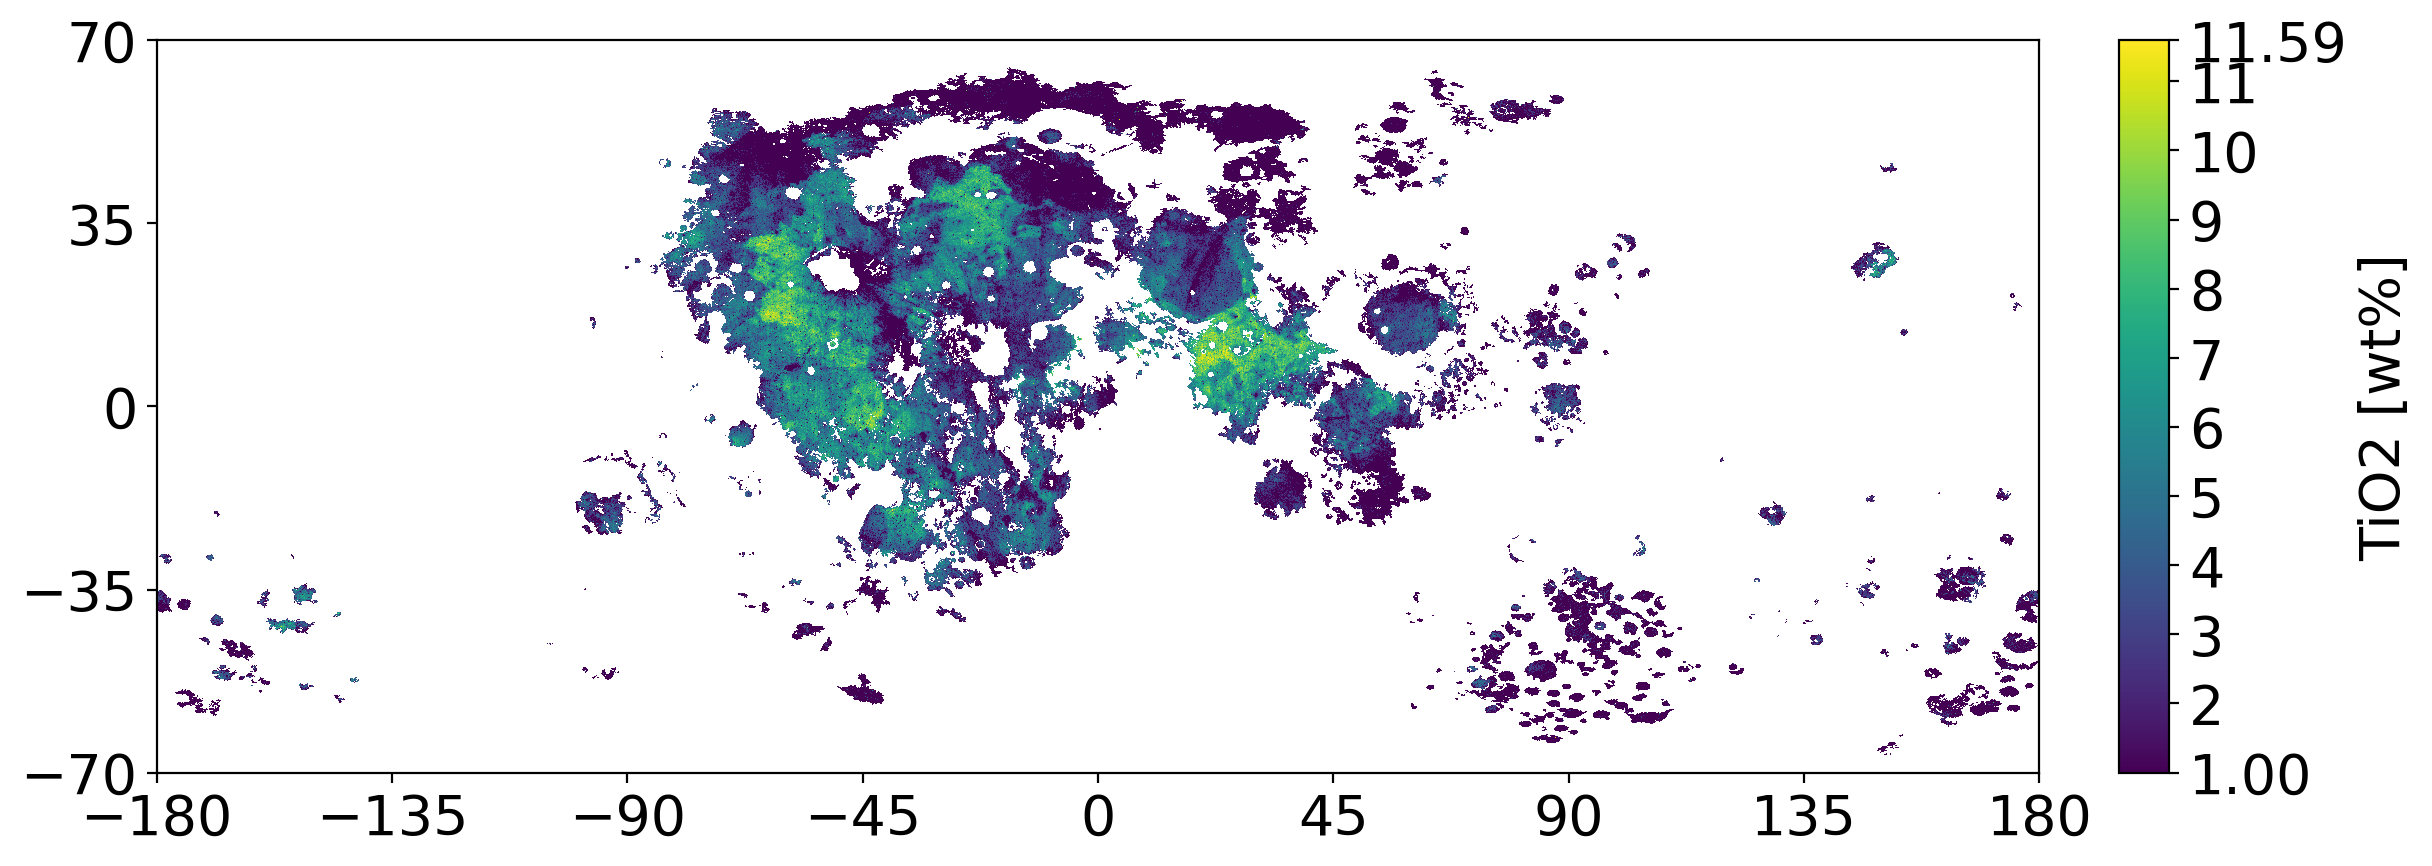

In [19]:
data = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_MARE.png"))
data = np.ma.masked_where(data == 0, data) # exclude values with zero
plot_map(data,22,'TiO2 [wt%]','TiO2',tuple((-70,70)),tuple((-180,180)))

display values (27360, 10640)
extrema 22 255
image value spread [ 22  44  66  88 110 132 154 176 198 220 242 255]
value_divided spread ['1.00', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '11.59']


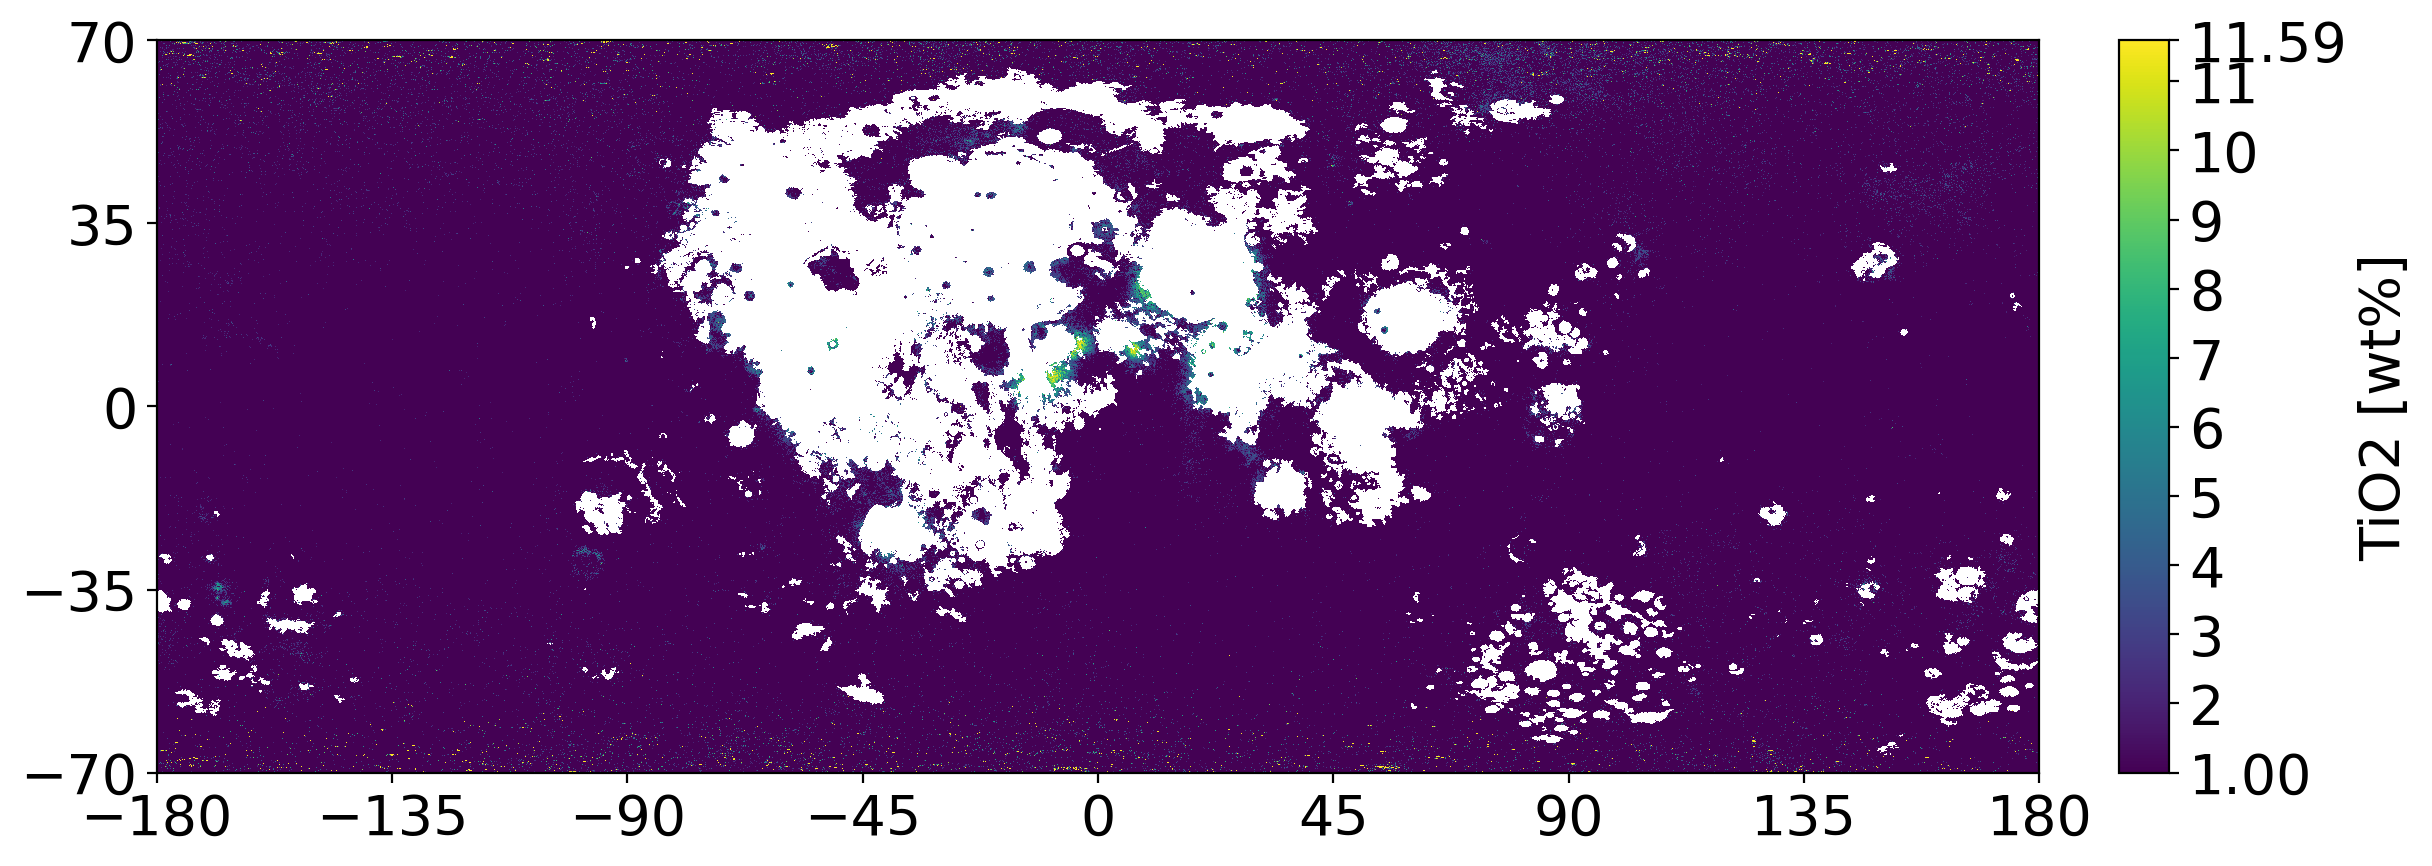

In [21]:
data = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_HIGH.png"))
data = np.ma.masked_where(data == 0, data) # exclude values with zero
plot_map(data,22,'TiO2 [wt%]','TiO2',tuple((-70,70)),tuple((-180,180)),labelsize=20,save="WAC_TIO2_GLOBAL_MASKED_HIGH.png")

### Helper functions for histogram

In [99]:
# counteract Equirectangular projection by calculating back spherical shape
# weighted by changing radius -> circumference over Lat

r_moon_avg = 1737400 # [m] volumetric mean 
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
# is used for readablity - will cancel out in weight calculation

def unit_radius_from_axis(unit_height):
    x = unit_height
    y = np.sqrt(1**2 - x**2)
    return y

def plot_histogram_compensate_Equirectangular(data,Lat_range,drop_zeros=None,color=None,verify=None):
    
    print(data.shape)
    lines, line_length = data.shape
    
    Lat_min , Lat_max = Lat_range # centered Lat_range required
    Lat_coverage = Lat_max - Lat_min 
    Lat_coverage_p = Lat_coverage/180
    print(Lat_coverage,'Lat_coverage',Lat_coverage_p)
    
    count_result = np.zeros(256)
    
    equator_circumference = 2 * np.pi * r_moon_avg
    

    for i in range(lines):
        
        # counting each line
        line_count = np.bincount(data[i])
        
        # compute weight for line by (circumference at position / equatorial circumference)
        dist_from_eq_px = 0.5 - ((lines/2) - i)
        unit_dist_from_eq = dist_from_eq_px / (lines/2) # 
        i_circumference = 2 * np.pi * (unit_radius_from_axis(unit_dist_from_eq*Lat_coverage_p) * r_moon_avg)
        #print(i,dist_from_eq_px,unit_dist_from_eq,i_circumference) #debug
        
        w = i_circumference / equator_circumference
        
        # add to stacked weighted countd
        for index, d in enumerate(line_count):
            count_result[index] += d * w

    if drop_zeros: count_result[0]=0
    
    # probability
    probability_result = np.zeros(256)
    count_sum = np.sum(count_result)
    
    
    for index, d in enumerate(count_result):
        probability_result[index] = count_result[index] / count_sum
    
    if verify: 
        print('Earths landmass probability',probability_result[0],'correct value', 0.292)
        return
    
    x = probability_result
    x = x.flatten()
    
    if drop_zeros: 
        avg = np.mean(data[data != 0])
    else:
        avg = np.mean(data)

    print("Equirectangular Average",avg)
    
    total_sum = 0
    for index, d in enumerate(count_result):
        total_sum += d * index
    
    avg = total_sum / np.sum(count_result)
    print("Equi. corrected Average",avg)
    
    plt.bar(range(256), x,color = color, lw=0, width=1.0)
    plt.ylabel('Probability')
    plt.xlabel('Data')
    plt.yscale('log')
    plt.show()
    plt.close()

verifying equirectangular correction by Earths landmass


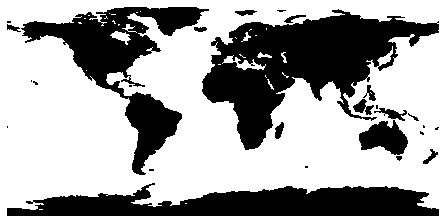

(5797, 12000)
180 Lat_coverage 1.0
Earths landmass probability 0.30831845708983 correct value 0.292


In [100]:
# verify function by landmass percentage of earth
print("verifying equirectangular correction by Earths landmass")
# create eath png
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(color="Black", antialiased=False)
plt.axis('off')

# remove all whitespace padding around canvas
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('maps\preparation\TiO2\Earth_verify.png', dpi=2000,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()
plt.close()

# convert image to Luminance 8 bit
im = Image.open("maps\preparation\TiO2\Earth_verify.png").convert('L')
im.save('maps\preparation\TiO2\Earth_verify.png')

# test "plot_histogram_compensate_Equirectangular()" on earth landmass
x = np.array(Image.open("maps\preparation\TiO2\Earth_verify.png"))
plot_histogram_compensate_Equirectangular(x,tuple((-90,90)), drop_zeros=False,color="darkcyan",verify=True)

# correct value 0.292
# http://www.physicalgeography.net/fundamentals/8o.html
# remaining error caused by "naturalearth_lowres" boundaries

### plot distribution of clustered areas: Mare | Highlands

(10640, 27360)
140 Lat_coverage 0.7777777777777778
Equirectangular Average 72.64976638886758
Equi. corrected Average 74.33460363163867


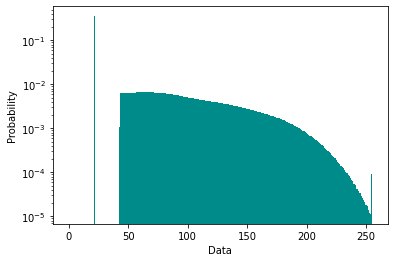

(10640, 27360)
140 Lat_coverage 0.7777777777777778
Equirectangular Average 24.38450820425185
Equi. corrected Average 24.254109777647958


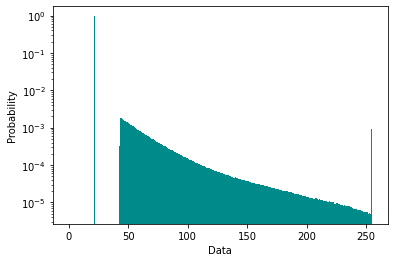

In [104]:
# distribution of result clustering
x = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_MARE.png"))
plot_histogram_compensate_Equirectangular(x,tuple((-70,70)), drop_zeros=True, color="darkcyan")

x = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_HIGH.png"))
plot_histogram_compensate_Equirectangular(x,tuple((-70,70)), drop_zeros=True, color="darkcyan")

### place combined map in global space

In [ ]:
# place combined map in global space

import sys
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

image = Image.open("WAC_TIO2_COMBINED_MAP.png")

width, height = image.size
print("width",width,end=" ")
print("height",height,end=" ")

aspect_ratio = width/height
print("aspect_ratio",aspect_ratio)
if aspect_ratio == 2:
    print("aspect ratio already matching.")
    exit(0)
else:
    print("adapting aspect ratio to 2")

if aspect_ratio < 2:
    print("Expanding width")
    print("ERROR:   Not implemented.")
    exit(0)

if aspect_ratio > 2:
    new_height = width/2
    if ((int(new_height) - height)% 2) == 0 :
        new_height = int(new_height)
    else:
        new_height = int(new_height)+1
    print("Expanding height to",new_height)
    add_lines = (new_height-height)/2
    print("adding",add_lines,"lines to the top and bottom")


    new_im = Image.new('L', (width, new_height))
    x_offset = 0
    y_offset = int(add_lines)
    new_im.paste(image, (x_offset,y_offset))

    new_im.save('WAC_TIO2_GLOBAL_MAP.png')
    #new_im.save('WAC_TIO2_GLOBAL_MAP.TIF')
    print('COMPLETED.')

### fill in Highlands and Poles with lower bound

In [ ]:
import cv2

image = cv2.imread('WAC_TIO2_GLOBAL_MAP.png',0)

mask = cv2.imread('LROC_GLOBAL_MARE_180_WAC_MASK.png',0)
mask_hand = cv2.imread('LROC_GLOBAL_MARE_180_WAC_MASK_HAND.png',0)
mask_neg = cv2.imread('LROC_GLOBAL_MARE_180_WAC_MASK_NEG.png',0)

result = cv2.bitwise_and(image, mask)
result[mask==0] = 22 # set background to 1 w%

result_omit = cv2.bitwise_and(image, mask_neg)
result_omit[result<22] = 255 # mark what will be set to 1 w% from below 1 w%

result[result<22] = 22 # set everything below 1% to 1 w%


result_hand = cv2.bitwise_and(image, mask_hand)
result_hand[mask_hand==0] = 22 # set background to 1 w%
result_hand[result_hand<22] = 22 # set everything below 1% to 1 w%


cv2.imwrite('WAC_TIO2_GLOBAL_MASKED_MAP.png', result)
cv2.imwrite('WAC_TIO2_GLOBAL_MASKED_MAP_HAND.png', result_hand)
cv2.imwrite('WAC_TIO2_GLOBAL_MASKED_OMITTED.png', result_omit)

print('COMPLETED.')


### plotting result Ilmenite map for paper Figure

## Global cost map for paper Figure

## plotting illumination map for extra reference